word2vec is a technique for encoding words (or other tokens in a sequence) into high dimensional vectors. These vectors can be used for similarity lookups and arithmetic operations. The word2vec algorithm is implemented by [gensim](https://radimrehurek.com/gensim/).

In [1]:
from gensim.models import Word2Vec

Instead of spending days training our own model on lots of text, we can load a pre-trained model. This one was [trained by Google](https://code.google.com/p/word2vec/) on three million unique words and phrases in news articles. Each word is embedded in a 300-dimensional space. It's a 3.6GB file (compressed to 1.6GB) and can take almost two minutes to load this model from disk.

In [2]:
model = Word2Vec.load_word2vec_format('../../models/word2vec/GoogleNews-vectors-negative300.bin.gz', binary=True)

We can look up the vector for a single word like this:

In [14]:
vector = model['Japan']
print(vector.shape)

(300,)


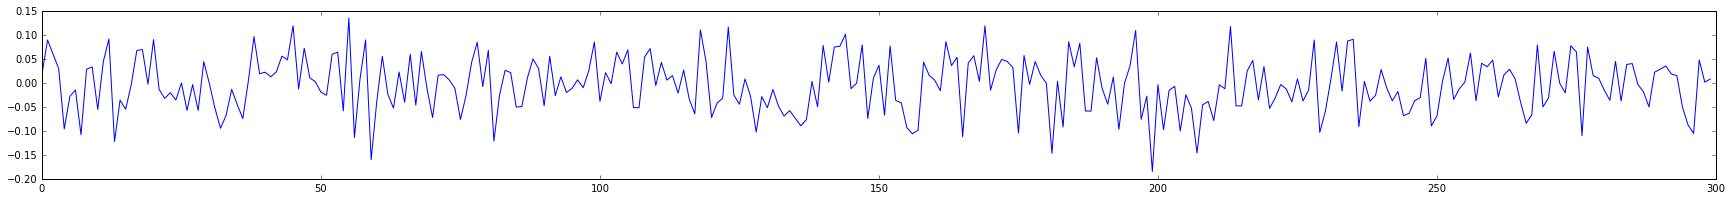

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[30, 3])
plt.plot(vector)
plt.show()

In [25]:
print vector

[  1.83295589e-02   9.02378261e-02   6.02760501e-02   3.04905158e-02
  -9.58776921e-02  -2.78468300e-02  -1.42759066e-02  -1.07862405e-01
   2.90805493e-02   3.40154320e-02  -5.49886748e-02   4.51189131e-02
   9.23527777e-02  -1.21962063e-01  -3.54253985e-02  -5.46361841e-02
  -3.34866927e-03   6.83833510e-02   7.01458082e-02  -2.12596450e-03
   9.09428075e-02  -1.32184317e-02  -3.19004804e-02  -2.00038925e-02
  -3.52491513e-02   5.01198869e-04  -5.71036264e-02  -3.08430078e-03
  -5.71036264e-02   4.49426658e-02  -7.38029077e-04  -5.21687418e-02
  -9.44677219e-02  -6.73258752e-02  -1.29540628e-02  -4.49426658e-02
  -7.40232170e-02   5.57377189e-03   9.72876549e-02   1.96514018e-02
   2.29119491e-02   1.33065544e-02   2.34406851e-02   5.63986413e-02
   4.89963219e-02   1.19847111e-01  -1.22490805e-02   7.29657412e-02
   1.12356665e-02   2.84196273e-03  -1.87701732e-02  -2.53793895e-02
   6.02760501e-02   6.48584366e-02  -5.81610985e-02   1.36061728e-01
  -1.13502264e-01   8.68010335e-03

If we sort the dimensions by one vector, we can see the similar words follow it, and the dissimilar one does not.

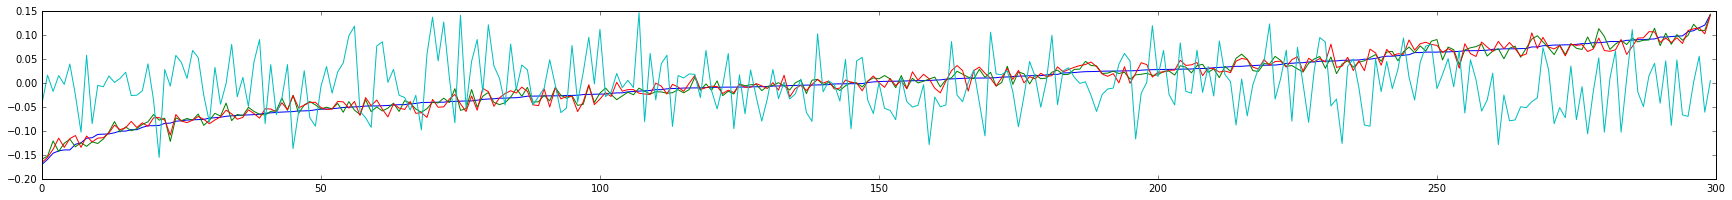

In [17]:
plt.figure(figsize=[30, 3])
plt.plot(sorted(zip(model['Tuesday'], model['Wednesday'], model['Thursday'], model['teapot'])))
plt.show()

Using these vectors we can make metaphors, such as "What is the Berlin of Japan (instead of Germany)?" also written:
`Berlin + Japan - Germany`:

In [6]:
model.most_similar(positive=['Berlin', 'Japan'], negative=['Germany'])

[(u'Tokyo', 0.7485347390174866),
 (u'Toyko', 0.61406409740448),
 (u'Japanese', 0.582942008972168),
 (u'Seoul', 0.5801318883895874),
 (u'Fukuoka', 0.5745269060134888),
 (u'Nagoya', 0.5597074627876282),
 (u'Aomori', 0.5552584528923035),
 (u'Osaka', 0.5507833361625671),
 (u'Tsuruoka', 0.5430541038513184),
 (u'Ishihara', 0.5422928333282471)]

Or, "What is a queen as a man (instead of a woman)?" Notice that the words are case sensitive.
`queen + man - woman`

In [21]:
model.most_similar(positive=['queen', 'man'], negative=['woman'])

[(u'tables', 0.45368924736976624),
 (u'bottles', 0.43423134088516235),
 (u'corked_bottle', 0.4132513403892517),
 (u'tray', 0.4065389037132263),
 (u'napkin_dispenser', 0.39898595213890076),
 (u'bar_stool', 0.3980811834335327),
 (u'napkin', 0.3903505802154541),
 (u'Diet_Coke_cans', 0.3782775402069092),
 (u'windowsill', 0.373889297246933),
 (u'fireplace_mantle', 0.373415470123291)]

We can look for the most similar words in the 1000 most common words.

In [124]:
limit = 1000
limited = model.index2word[:limit]
matches = [(model.most_similar(positive=[word], topn=1, restrict_vocab=limit)[0], word) for word in limited]
sorted([(x[1],x[0],y) for x,y in matches], reverse=True)[:200]

[(0.98166823387146, u'Wednesday', u'Thursday'),
 (0.98166823387146, u'Thursday', u'Wednesday'),
 (0.979229211807251, u'Wednesday', u'Tuesday'),
 (0.9720568656921387, u'Tuesday', u'Monday'),
 (0.9703431129455566, u'three', u'four'),
 (0.9703431129455566, u'four', u'three'),
 (0.9675939679145813, u'January', u'February'),
 (0.9675939083099365, u'February', u'January'),
 (0.963593602180481, u'February', u'October'),
 (0.9619012475013733, u'seven', u'eight'),
 (0.9619012475013733, u'eight', u'seven'),
 (0.9616836309432983, u'May', u'April'),
 (0.9616836309432983, u'April', u'May'),
 (0.9606298208236694, u'four', u'five'),
 (0.9601358771324158, u'April', u'March'),
 (0.9579434394836426, u'October', u'August'),
 (0.9557317495346069, u'June', u'July'),
 (0.9557317495346069, u'July', u'June'),
 (0.9544944763183594, u'October', u'September'),
 (0.9543241858482361, u'3', u'2'),
 (0.9543241858482361, u'2', u'3'),
 (0.9529384970664978, u'6', u'5'),
 (0.9529384970664978, u'5', u'6'),
 (0.9525634646

gensim also provides interfaces for how similar two words are.

In [35]:
model.similarity('computer', 'calculator')

0.28810833963482396

In [40]:
model.similarity('computer', 'rain')

0.11930465328781076

Or which words don't belong, like "[Which one of these things is not like the other](https://www.youtube.com/watch?v=gCxrkl2igGY)".

In [41]:
model.doesnt_match('hammer shoe handsaw pliers'.split()) # try "saw" instead

'see'

In [44]:
model.doesnt_match("sweet sour salty wet".split()) # add umami

'wet'

As you work with word2vec you will notice that opposites are more similar to each other than they are to very different things:

In [45]:
model.similarity('hot', 'cold')

0.71900512146338558

In [49]:
model.similarity('hot', 'laptop')

0.091948770182133571

For a set of words we can plot their similarities to each other, and see that each group of three is similar to each other but not to the others.

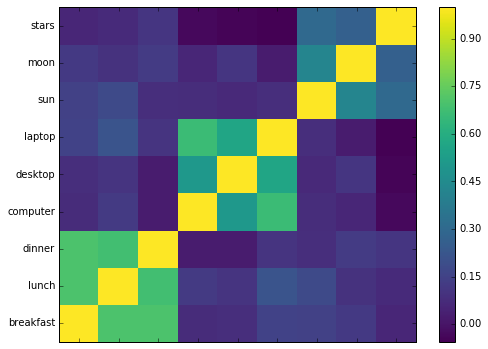

In [125]:
import numpy as np

# words = [str(i) for i in range(9)]
# words = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eighth', 'ninth', 'tenth', 'eleventh', 'twelfth']
# words = ['January','February','March','April','May','June','July','August','September','October','November','December']
# words = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
words = ['breakfast', 'lunch', 'dinner',
        'computer', 'desktop', 'laptop',
        'sun', 'moon', 'stars']
vectors = [model[word] for word in words]
similar = [np.dot(vectors, vector) for vector in vectors]

plt.figure(figsize=(8, 6))
plt.pcolor(np.array(similar), cmap='viridis')
plt.colorbar()
plt.yticks(0.5 + np.arange(len(words)), words)
plt.xticks(0.5 + np.arange(len(words)), '' * len(words))
plt.show()

Another idea is to find a path from one word to another. Instead of doing a linear interpolation from one vector to another, we need to do a high-dimensional spherical interpolation. This example uses code from [Transorthogonal Linguistics](https://github.com/thoppe/transorthogonal-linguistics/blob/master/transorthogonal_linguistics/slerp_word_path.py). They do some extra filtering to get better results, and you can test it [here](http://transorthogonal-linguistics.herokuapp.com/TOL/boy/man).

In [71]:
from gensim import matutils
def slerp_points(x0,x1,slerp_n):
    theta = np.arccos(x0.dot(x1))
    st = np.sin(theta)
    T  = np.linspace(0,1,slerp_n)
    L1 = np.sin((1-T)*theta)/st
    L2 = np.sin(T*theta)/st
    SL = np.outer(L1,x0) + np.outer(L2,x1)
    return (SL.T / np.linalg.norm(SL,axis=1)).T
def print_path(start, end, steps=10, limit=100000, topn=10):
    x0 = model[start]
    x1 = model[end]
    all_words = [start, end]
    between = slerp_points(x0, x1, steps)
    limited = model.syn0norm if limit is None else model.syn0norm[:limit]
    for x in between:
        sims = np.dot(limited, matutils.unitvec(x))
        best = matutils.argsort(sims, topn=topn, reverse=True)
        print ' '.join([model.index2word[i] for i in best if not model.index2word[i] in all_words])

In [72]:
print_path('baby', 'adult')

newborn babies infant newborn_baby toddler child triplets Baby newborns
newborn infant babies newborn_baby toddler child newborns triplets unborn_baby
newborn infant babies newborn_baby child toddler newborns infants unborn_baby
infant newborn babies child toddler newborn_baby newborns infants
infant newborn child babies toddler newborn_baby toddlers infants
infant child newborn toddler babies toddlers children infants
infant child toddlers newborn adults Adult toddler children
Adult adults infant child adolescent toddlers children teen toddler
Adult adults adolescent child teen toddlers children infant preteen
Adult adults adolescent ages Adults preteen teen juvenile teens


If you have a set of words you can sort them so that the path from one word to the next is always similar. This can be done with a traveling salesperson solver, like [this one in Python](https://github.com/dmishin/tsp-solver) or [this one from Google](https://developers.google.com/optimization/routing/tsp?hl=en). Here's a [list of moods](https://gist.github.com/kylemcdonald/e425243c41b2c41de5ba) sorted by a traveling salesperson solver their word2vec vector distance: `...fearless courageous brave daring bold framed blank fake phony inflated manipulated...`

We can also use PCA or t-SNE to plot a collection of word2vec vectors in 2d. Let's see if there is a principle axis that the "capital city" relationship exists along.

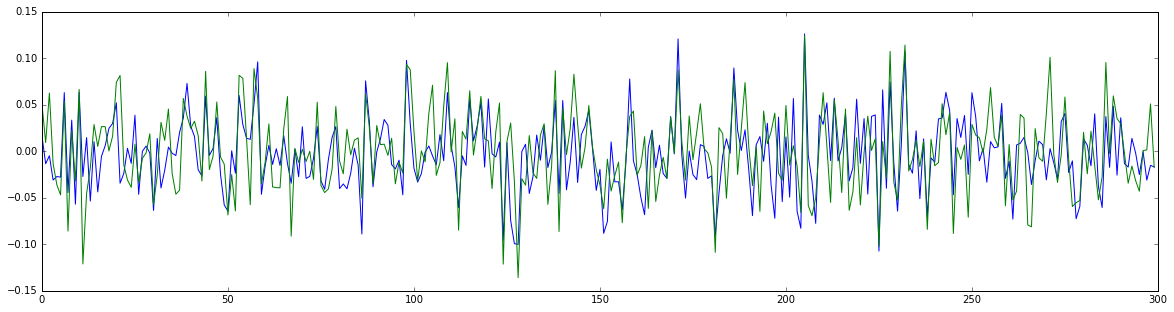

In [126]:
plt.figure(figsize=(20, 5))
plt.plot(model['China']-model['Beijing'])
plt.plot(model['Japan']-model['Tokyo'])
# plt.plot(model['man']-model['woman'])
plt.show()

In [128]:
pairs = [
    'China', 'Beijing',
    'Japan', 'Tokyo',
    'Russia', 'Moscow',
    'South_Korea', 'Seoul',
    'Indonesia', 'Jakarta',
    'United_Kingdom', 'London',
    'Peru', 'Lima',
    'Thailand', 'Bangkok',
    'Iran', 'Tehran',
    'Egypt', 'Cairo']
# pairs = [
#     'eyes', 'glasses',
#     'hand', 'pencil',
#     'head', 'hat',
#     'feet', 'shoes',
#     'legs', 'pants']
pairs_vectors = [model[pair] for pair in pairs]

In [129]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pairs_pca = pca.fit_transform(pairs_vectors)

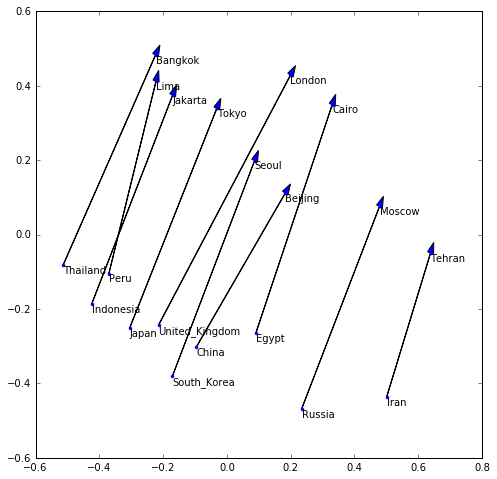

In [130]:
plt.figure(figsize=(8,8))
plt.plot(pairs_pca[:,0], pairs_pca[:,1], '.')
pair_pts = zip(pairs_pca[::2], pairs_pca[1::2])
pair_names = zip(pairs[::2], pairs[1::2])
for pt_pair, name_pair in zip(pair_pts, pair_names):
    pt0, pt1 = pt_pair
    plt.arrow(pt0[0], pt0[1], pt1[0]-pt0[0], pt1[1]-pt0[1])
    name0, name1 = name_pair
    plt.annotate(name0, pt0, va='top')
    plt.annotate(name1, pt1, va='top')
plt.show()

If you look at the relationship between a bunch of countries, you'll see the most related countries ending up next to each other. _Note: Some Countries are missing because they're not in word2vec._ For more words check out [corpora](https://github.com/dariusk/corpora).

In [139]:
words = []
with open('animals.txt') as f:
    words = [line.strip() for line in f]
print(len(words))
print(words)

134
['aardvark', 'alligator', 'alpaca', 'antelope', 'ape', 'armadillo', 'baboon', 'badger', 'bat', 'bear', 'beaver', 'bison', 'boar', 'buffalo', 'bull', 'camel', 'canary', 'capybara', 'cat', 'chameleon', 'cheetah', 'chimpanzee', 'chinchilla', 'chipmunk', 'cougar', 'cow', 'coyote', 'crocodile', 'crow', 'deer', 'dingo', 'dog', 'donkey', 'dromedary', 'elephant', 'elk', 'ewe', 'ferret', 'finch', 'fish', 'fox', 'frog', 'gazelle', 'gila_monster', 'giraffe', 'gnu', 'goat', 'gopher', 'gorilla', 'grizzly_bear', 'groundhog', 'guinea_pig', 'hamster', 'hedgehog', 'hippopotamus', 'hog', 'horse', 'hyena', 'ibex', 'iguana', 'impala', 'jackal', 'jaguar', 'kangaroo', 'koala', 'lamb', 'lemur', 'leopard', 'lion', 'lizard', 'llama', 'lynx', 'mandrill', 'marmoset', 'mink', 'mole', 'mongoose', 'monkey', 'moose', 'mountain_goat', 'mouse', 'mule', 'muskrat', 'mustang', 'mynah_bird', 'newt', 'ocelot', 'opossum', 'orangutan', 'oryx', 'otter', 'ox', 'panda', 'panther', 'parakeet', 'parrot', 'pig', 'platypus', 'p

We need to replace ' ' with '_' in the phrases, and ignore any words/phrases that don't appear in word2vec.

In [144]:
words_vectors = []
for word in words:
    try:
        token = word.replace(' ', '_')
        words_vectors.append(model[token])
    except KeyError:
        print 'Ignoring "' + word + '"'

In [113]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, perplexity=10, learning_rate=100, verbose=2)
%time countries_tsne = tsne.fit_transform(countries_vectors)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 0.319127
[t-SNE] Iteration 25: error = 1.2483724, gradient norm = 0.0251888
[t-SNE] Iteration 50: error = 1.0695069, gradient norm = 0.0170180
[t-SNE] Iteration 75: error = 0.7517845, gradient norm = 0.0045418
[t-SNE] Iteration 100: error = 0.7133048, gradient norm = 0.0037676
[t-SNE] Error after 100 iterations with early exaggeration: 0.713305
[t-SNE] Iteration 125: error = 0.6629950, gradient norm = 0.0027995
[t-SNE] Iteration 150: error = 0.6485704, gradient norm = 0.0026551
[t-SNE] Iteration 175: error = 0.6450387, gradient norm = 0.0026016
[t-SNE] Iteration 200: error = 0.6441799, gradient norm = 0.0025663
[t-SNE] Iteration 225: error = 0.6439406, gradient norm = 0.0025545
[t-SNE] Iteration 250: error = 0.6438839, gradient norm = 0.0025508
[t-SNE] Iteration 275: error = 0.6438654, gradient norm = 0.0025498
[t-SNE] Ite

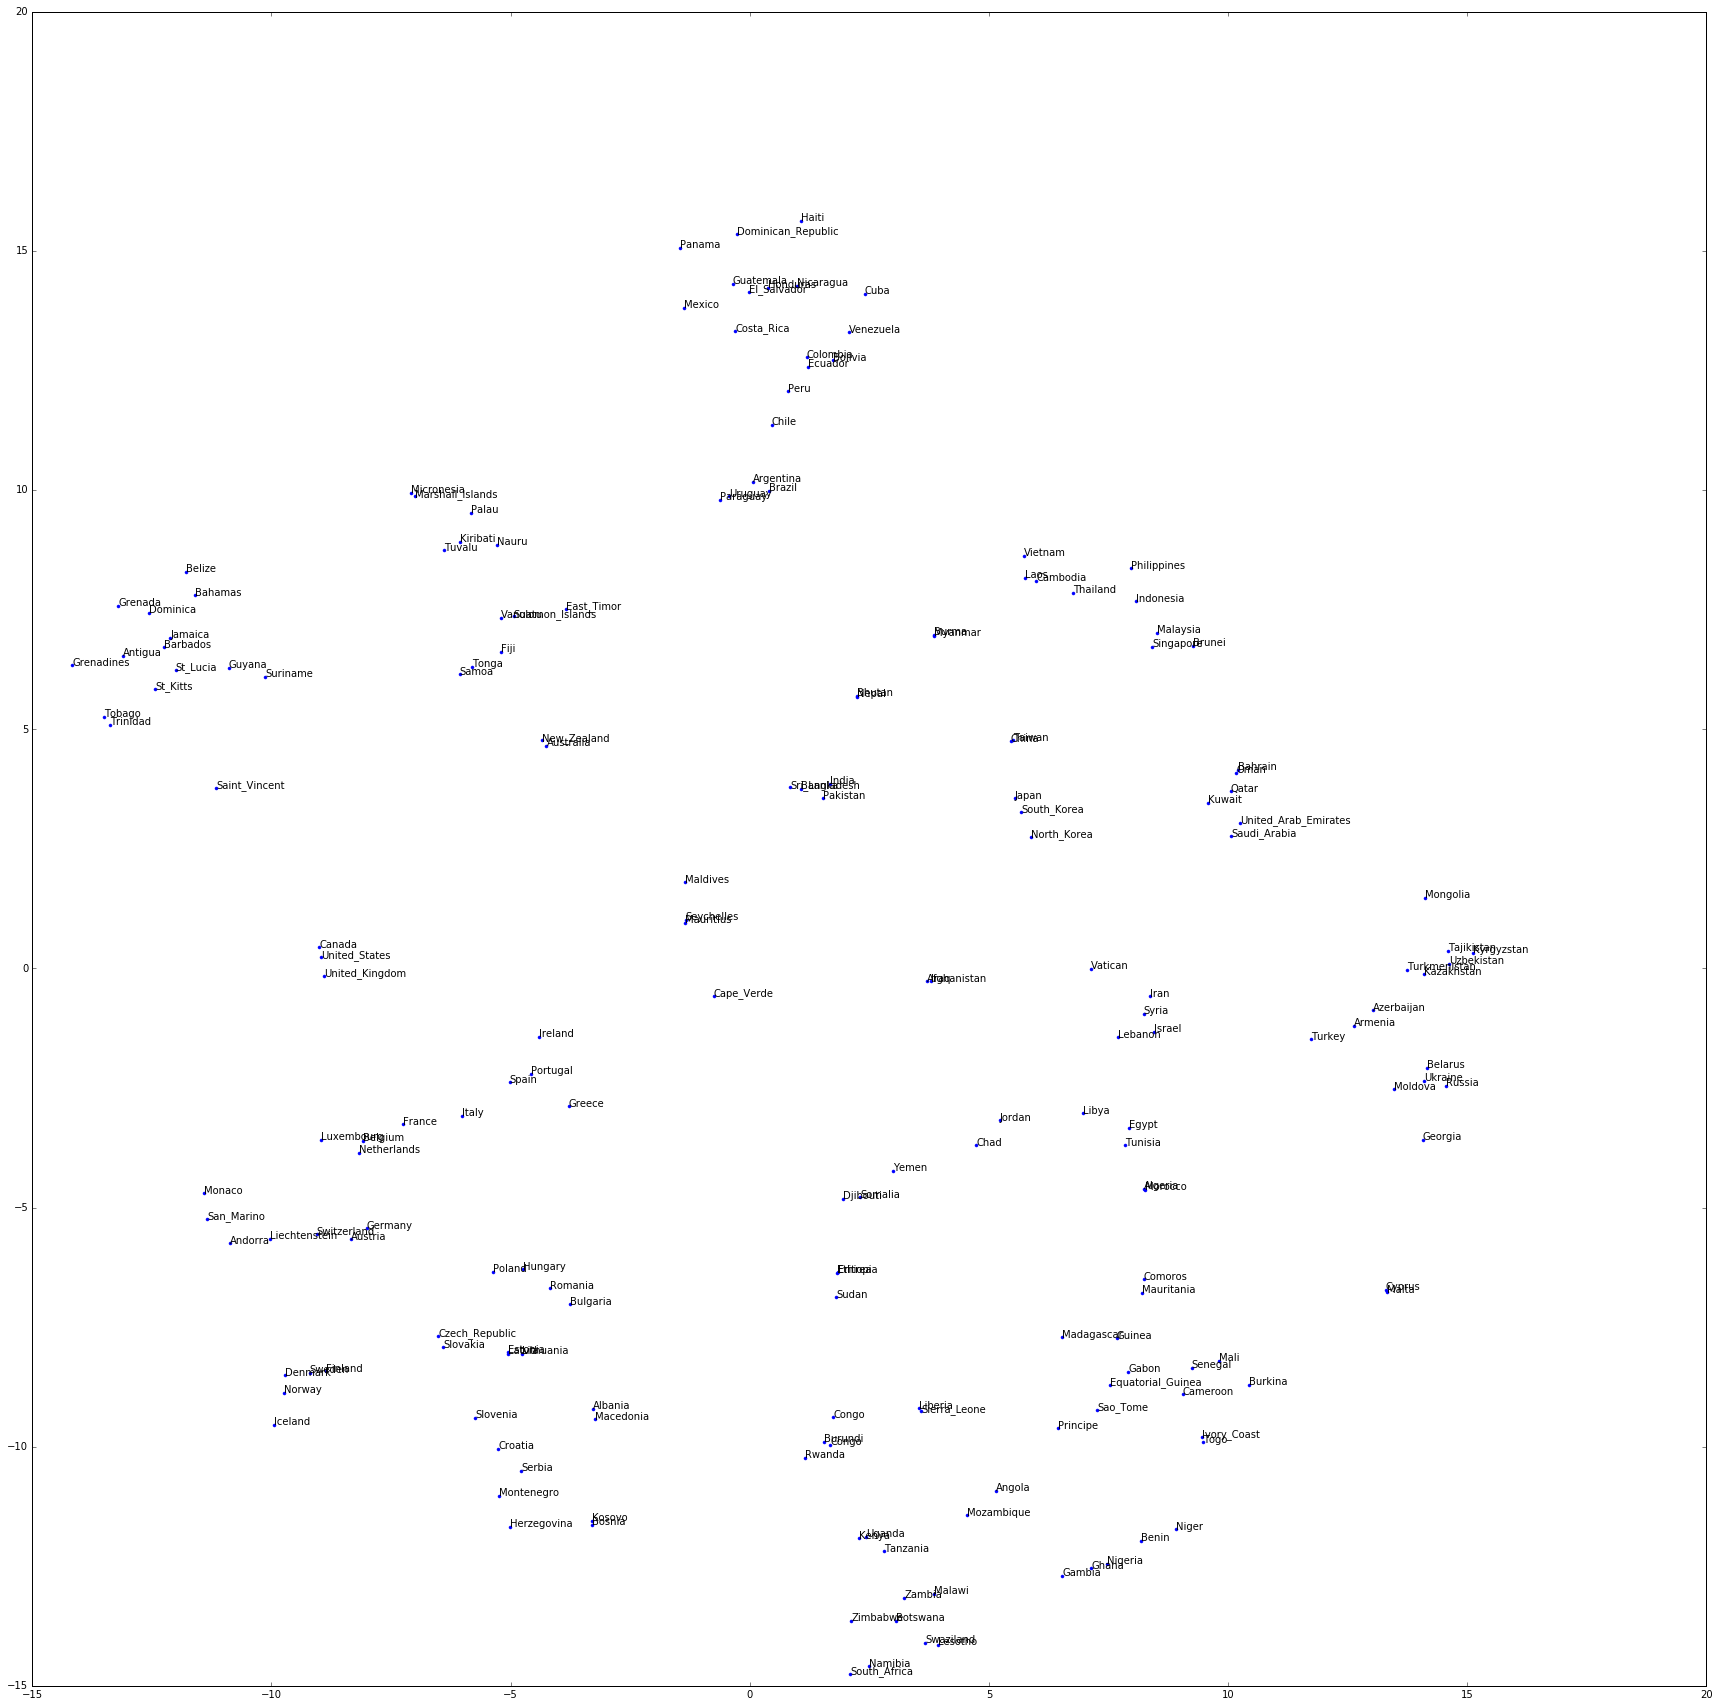

In [114]:
plt.figure(figsize=(30,30))
plt.plot(countries_tsne[:,0], countries_tsne[:,1], '.')
for pt, name in zip(countries_tsne, countries):
    plt.annotate(name, pt)
plt.show()